# Unsupervised concept drift detectors: SyncStream & SCD



In [1]:
import pandas as pd
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder

import numpy as np
import math
from sklearn.decomposition import PCA
from scipy.stats import rankdata, norm, gaussian_kde
from sklearn.utils import resample
from statistics import variance

import matplotlib.pyplot as plt
from time import time

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import sklearn
import category_encoders
import scipy

print(sklearn.__version__)
print(category_encoders.__version__)
print(scipy.__version__)

1.0.2
2.5.1.post0
1.9.1


### Reading the SEA dataset

In [2]:
def read_sea(filename):
    data, meta = arff.loadarff(filename)
    df = pd.DataFrame(data)
#     df = df.iloc[54450:55450,:] # For testing SCD with miniature scale
    
    X = df[["attrib1", "attrib2", "attrib3"]]
    
    X_train, X_test = train_test_split(X, train_size=0.30, shuffle=False)
    
    return X_train, X_test

### Reading the AGRAW dataset

In [3]:
def read_agraw(filename):
    data, meta = arff.loadarff(filename)
    df = pd.DataFrame(data)

    le = LabelEncoder()
#     te = TargetEncoder(cols=["elevel", "car", "zipcode"], smoothing=0, return_df=False)
#     ohe = OneHotEncoder()
#     oe = OrdinalEncoder()

    X = df.drop(columns=["class"])
    y = le.fit_transform(df["class"].str.decode("utf-8"))

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.30, shuffle=False)

#     encoder = 'target'
    
#     if encoder == 'onehot':
#         # OneHotEncoder
#         X_train_num = X_train.drop(columns=["elevel", "car", "zipcode"])
#         X_train_cat = X_train[["elevel", "car", "zipcode"]]
#         X_train_cat = ohe.fit_transform(X_train_cat).toarray()
#         X_train = np.concatenate([X_train_num, X_train_cat], axis=1)
#         X_test_num = X_test.drop(columns=["elevel", "car", "zipcode"])
#         X_test_cat = X_test[["elevel", "car", "zipcode"]]
#         X_test_cat = ohe.transform(X_test_cat).toarray()
#         X_test = np.concatenate([X_test_num, X_test_cat], axis=1)
#     elif encoder == 'ordinal':
#         # OrdinalEncoder
#         X_train_num = X_train.drop(columns=["elevel", "car", "zipcode"])
#         X_train_cat = X_train[["elevel", "car", "zipcode"]]
#         X_train_cat = oe.fit_transform(X_train_cat)
#         X_train = np.concatenate([X_train_num, X_train_cat], axis=1)
#         X_test_num = X_test.drop(columns=["elevel", "car", "zipcode"])
#         X_test_cat = X_test[["elevel", "car", "zipcode"]]
#         X_test_cat = oe.transform(X_test_cat)
#         X_test = np.concatenate([X_test_num, X_test_cat], axis=1)
#     elif encoder == 'target':
#         # TargetEncoder
#         X_train = te.fit_transform(X_train, y_train)
#         X_test = te.transform(X_test)
    
    return X_train, X_test, y_train, y_test

### Preprocessing

In [4]:
# def preprocess(X_train, X_test, total_batches):
#     scaler = MinMaxScaler()

#     X_train = pd.DataFrame(scaler.fit_transform(X_train))
#     X_test = pd.DataFrame(scaler.transform(X_test))

#     X_test_batches = np.array_split(X_test, total_batches)

#     return X_train, X_test_batches

def ensure_df(data):
    checked_data = data
    if not isinstance(data, pd.DataFrame):
        checked_data = pd.DataFrame(data)
    return checked_data

def encode(ref_data, test_batches, ref_labels, encoder=None):
    encoded_ref_data = ref_data
    encoded_test_batches = test_batches
    
    if encoder == 'onehot':
        # OneHotEncoder
        ohe = OneHotEncoder()
        ref_data_num = ref_data.select_dtypes(include=[np.number])
        ref_data_cat = ref_data.select_dtypes(exclude=[np.number])
        encoded_ref_data_cat = ohe.fit_transform(ref_data_cat).toarray()
        encoded_ref_data = pd.DataFrame(np.concatenate([ref_data_num, encoded_ref_data_cat], axis=1))
        encoded_test_batches = []
        for batch in range(len(test_batches)):
            test_data_num = test_batches[batch].select_dtypes(include=[np.number])
            test_data_cat = test_batches[batch].select_dtypes(exclude=[np.number])
            encoded_test_data_cat = ohe.transform(test_data_cat).toarray()
            encoded_test_batches.append(pd.DataFrame(np.concatenate([test_data_num, encoded_test_data_cat], axis=1)))
    elif encoder == 'ordinal':
        # OrdinalEncoder
        oe = OrdinalEncoder()
        ref_data_num = ref_data.select_dtypes(include=[np.number])
        ref_data_cat = ref_data.select_dtypes(exclude=[np.number])
        encoded_ref_data_cat = oe.fit_transform(ref_data_cat)
        encoded_ref_data = pd.DataFrame(np.concatenate([ref_data_num, encoded_ref_data_cat], axis=1))
        encoded_test_batches = []
        for batch in range(len(test_batches)):
            test_data_num = test_batches[batch].select_dtypes(include=[np.number])
            test_data_cat = test_batches[batch].select_dtypes(exclude=[np.number])
            encoded_test_data_cat = oe.transform(test_data_cat)
            encoded_test_batches.append(pd.DataFrame(np.concatenate([test_data_num, encoded_test_data_cat], axis=1)))
    elif encoder == 'target' and ref_labels is not None:
        # TargetEncoder
        cols = ref_data.select_dtypes(exclude=[np.number]).columns
        te = TargetEncoder(cols, smoothing=0, return_df=True)
        encoded_ref_data = te.fit_transform(ref_data, ref_labels)
        encoded_test_batches = []
        for batch in range(len(test_batches)):
            encoded_test_batches.append(te.transform(test_batches[batch]))
        
    return encoded_ref_data, encoded_test_batches
    
def scale(ref_data, test_batches, scaler=None):
    scaled_ref_data = ref_data
    scaled_test_batches = test_batches
    
    if scaler == 'minmax':
        mms = MinMaxScaler()
        scaled_ref_data = pd.DataFrame(mms.fit_transform(ref_data))
        scaled_test_batches = list(map(lambda batch: pd.DataFrame(mms.transform(batch)), test_batches))
        
    return scaled_ref_data, scaled_test_batches

### Postprocessing

In [5]:
def postprocess(real_drift, detected_drifts, total_batches):
    if len(detected_drifts) <= 0:
        return 0.0, 1.0
    else:
        false_positives = list(filter(lambda flagged_batch: flagged_batch < real_drift, detected_drifts))
        false_positive_rate = len(false_positives) / (real_drift - 1)
        if false_positive_rate < 0:
            false_positive_rate = 0.0
            
        first_detected_drift = detected_drifts[0]
        for i in range(len(detected_drifts)):
            if detected_drifts[i] >= real_drift:
                first_detected_drift = detected_drifts[i]
                break
        latency = (first_detected_drift - real_drift) / (total_batches - real_drift)
        if latency < 0:
            latency = 1.0
            
        return false_positive_rate, latency
    
def postprocess_rw(real_drifts, detected_drifts, n_batches):
    if len(detected_drifts) <= 0:
        return 0.0, 0.0
    else:
        false_positives = list(filter(lambda detected_drift: detected_drift not in real_drifts, detected_drifts))
        correct_positives = list(filter(lambda real_drift: real_drift in detected_drifts, real_drifts))

        false_positive_rate = len(false_positives) / (n_batches - len(real_drifts))
        accuracy = len(correct_positives) / len(real_drifts)
        
        return false_positive_rate, accuracy
    
    
def graph(deltas, crits, y_label, deltas_reverse=None, crits_reverse=None):
    print(deltas)
    print(crits)
    print(y_label)
    print(deltas_reverse)
    print(crits_reverse)
    
    plt.ylabel(y_label)
    plt.xlabel("Test batch")
    x_range = np.arange(1, len(deltas) + 1)
    
    bar_width = 0.5
    offset = 0
    if deltas_reverse:
        bar_width = 0.25
        offset = 0.125
    
    plt.bar(x_range - offset, deltas, width=bar_width, color="b")
    plt.plot(x_range - offset, crits, "r-")
    if deltas_reverse:
        plt.bar(x_range + offset, deltas_reverse, width=bar_width, color="c")
        plt.plot(x_range + offset, crits_reverse, "m-")
        
    plt.show()

### SyncStream-PCA

In [6]:
def syncstream_pca_all(raw_ref_data, raw_test_batches, ref_labels=None, encoder=None, scaler=None, consecutive=False):
    
    # Make sure data is in DataFrames
    ref_data = ensure_df(raw_ref_data)
    test_batches = []
    for batch in range(len(raw_test_batches)):
        test_batches.append(ensure_df(raw_test_batches[batch]))
    
    # Encode and scale the data
    if encoder:
        ref_data, test_batches = encode(ref_data, test_batches, ref_labels, encoder)
    if scaler:
        ref_data, test_batches = scale(ref_data, test_batches, scaler)
        
    print(test_batches[0].head())

    deltas = []
    crits = []
    drifts = []

    pca = PCA(n_components=1)

    pca.fit(ref_data.values)
    ref_eigenvector = pca.components_[0]

    for batch in range(len(test_batches)):
        pca.fit(test_batches[batch].values)
        batch_eigenvector = pca.components_[0]
        measured_angle = np.degrees(np.arccos(np.dot(batch_eigenvector, ref_eigenvector)))
        crit = 30
        
        if (consecutive):
            ref_eigenvector = batch_eigenvector
        
        deltas.append(measured_angle)
        crits.append(crit)
        if (measured_angle > crit):
            drifts.append(batch + 1)
    
    y_label = "SyncStream-PCA"
    if consecutive:
        y_label += " (consecutive)"
    else:
        y_label += " (fixed reference)"
    graph(deltas, crits, y_label)

    return drifts
    
def syncstream_pca(ref_data, test_data, ref_labels=None, encoder=None, scaler=None):
    drifts = syncstream_pca_all(ref_data, [test_data], ref_labels, encoder, scaler)
    return len(drifts) == 1
    

### SyncStream-Stat

In [7]:
def midrank(Dt, ranks_in_union, start_i, j):
    rank_sum = 0
    for i in range(start_i, start_i + len(Dt)):
        rank_sum += ranks_in_union[i]
    return rank_sum / len(Dt)

def v2(Dt, u, start_i):
    rank_diff_sum = 0
    for j in range(Dt.shape[1]):
        ranks_in_union = rankdata(u[:, j])
        ranks_in_Dt = rankdata(Dt[:, j])
        midrank_j = midrank(Dt, ranks_in_union, start_i, j)
        for i in range(0, len(Dt)):
            rank_diff_sum += (ranks_in_union[start_i + i] - ranks_in_Dt[i] - midrank_j + (len(Dt) + 1) / 2) ** 2
    return (1 / (len(Dt) - 1)) * rank_diff_sum

def midrank_diff(Dt, Dt1, u, j):
    ranks_in_union = rankdata(u[:, j])
    return midrank(Dt, ranks_in_union, 0, j) - midrank(Dt1, ranks_in_union, len(Dt), j)

def wilcoxon_test(Dt, Dt1, p):
    u = np.concatenate((Dt, Dt1))
    v2_Dt = v2(Dt, u, 0)
    v2_Dt1 = v2(Dt1, u, len(Dt))
    var_BF = (len(Dt) + len(Dt1)) * v2_Dt / len(Dt1) + (len(Dt) + len(Dt1)) * v2_Dt1 / len(Dt)
    sd_BF = np.sqrt(var_BF)
    midrank_diff_sum = 0
    for j in range(Dt.shape[1]):
        midrank_diff_sum += midrank_diff(Dt, Dt1, u, j)
    WBF = np.sqrt(len(Dt) * len(Dt1) / (len(Dt) + len(Dt1))) * midrank_diff_sum / sd_BF
    crit = norm.ppf(1-p/2)
    return abs(WBF) > crit, abs(WBF), crit

def syncstream_stat_all(raw_ref_data, raw_test_batches, ref_labels=None, encoder=None, scaler=None, p=0.01, consecutive=False):
    
    # Make sure data is in DataFrames
    ref_data = ensure_df(raw_ref_data)
    test_batches = []
    for batch in range(len(raw_test_batches)):
        test_batches.append(ensure_df(raw_test_batches[batch]))
    
    # Encode and scale the data
    if encoder:
        ref_data, test_batches = encode(ref_data, test_batches, ref_labels, encoder)
    if scaler:
        ref_data, test_batches = scale(ref_data, test_batches, scaler)
    
    print(test_batches[0].head())
    
    deltas = []
    crits = []
    drifts = []

    for batch in range(len(test_batches)):
        ref_batch = ref_data
        if consecutive and batch != 0:
            ref_batch = test_batches[batch - 1]
        detected_stat, delta, crit = wilcoxon_test(ref_batch.values, test_batches[batch].values, p)
        deltas.append(delta)
        crits.append(crit)
        if (detected_stat):
            drifts.append(batch + 1)
    
    y_label = "SyncStream-Stat"
    if consecutive:
        y_label += " (consecutive)"
    else:
        y_label += " (fixed reference)"
    graph(deltas, crits, y_label)
    
    return drifts

def syncstream_stat(ref_data, test_data, ref_labels=None, encoder=None, scaler=None, p=0.01):
    drifts = syncstream_stat_all(ref_data, [test_data], ref_labels, encoder, scaler, p)
    return len(drifts) == 1

### SCD

In [8]:
# Gaussian kernel function

# def g_kernel(bandwidth, diff):
#     k = len(diff)
#     det = np.linalg.det(bandwidth)
#     inv = np.linalg.inv(bandwidth)
#     exponent_matrix = np.matmul(np.matmul(diff.T, inv), diff)
#     return (1 / (np.sqrt(2 * np.pi)**k * np.sqrt(det))) * np.exp((-1 / 2) * exponent_matrix)


# Learning bandwidths with Expectation Maximization

# def init_bandwidths(n, k):
#     print('n', n)
#     print('k', k)
#     bandwidths = []
#     for i in range(n):
#         bandwidths.append(np.identity(k))
#     return bandwidths

# def soft_membership(bandwidth, S1, i, j):
#     if i == j:
#         return 0
#     density_sum = 0
#     for t in range(len(S1)):
#         if t != j:
#             density_sum += g_kernel(bandwidth, S1[j] - S1[t])
#     return g_kernel(bandwidth, S1[j] - S1[i]) / density_sum

# def bandwidth_update(i, S1, bandwidths):
#     nominator_sum = np.zeros((len(S1[0]), len(S1[0])))
#     denominator_sum = 0
#     for j in range(len(S1)):
#         soft_mb = soft_membership(bandwidths[i], S1, i, j)
#         point_kernel_diff = S1[j] - S1[i]
#         nominator_sum += soft_mb * np.outer(point_kernel_diff, point_kernel_diff.T)
#         denominator_sum += soft_mb
#     return nominator_sum / denominator_sum

# def pseudo_LLH(S1, bandwidths):
#     LLH = 0
#     for j in range(len(S1)):
#         temp_sum = 0
#         for i in range(len(S1)):
#             if i != j:
#                 temp_sum += (1 / (len(S1) - 1)) * g_kernel(bandwidths[i], S1[j] - S1[i])
#         LLH += np.log(temp_sum)
#     return LLH

# def learn_bandwidths(S1, maxIteration, phi):
#     bandwidths = init_bandwidths(len(S1), len(S1[0]))
#     L = []
#     for t in range(maxIteration):
#         # compute density for all i, j
#         # compute soft membership for all i, j
#         # compute new bandwidth for all i
#         for i in range(len(bandwidths)):
#             bandwidths[i] = bandwidth_update(i, S1, bandwidths)
#         # compute L and check for stopping criterion
#         L.append(pseudo_LLH(S1, bandwidths))
#         print(L[t])
#         if t > 0:
#             if (((L[t] - L[t - 1]) / L[t - 1]) < phi):
#                 break
#     return bandwidths


# The test statistic

# def density_estimate(S1, bandwidths, s):
#     density = 0
#     for i in range(len(S1)):
#         density += (1 / len(S1)) * g_kernel(bandwidths[i], s - S1[i])
#     return density

# def log_likelihood(bandwidths, S1, data, kde):
#     LLH = 0
#     for y in range(len(data)):
#         LLH += np.log(density_estimate(S1, bandwidths, data[y]))
#     return LLH

def delta(S1, S2, Sprime, kde):
#     return log_likelihood(bandwidths, S1, Sprime, kde) 
#         - (len(Sprime) / len(S2)) * log_likelihood(bandwidths, S1, S2, kde)
    return np.sum(kde.logpdf(Sprime.T)) - (len(Sprime) / len(S2)) * np.sum(kde.logpdf(S2.T)) # drop-in replacement


# Determining the critical value
    
def est_var_estimates(S2, estSize, kde):
    est_time = time()
    Est = []
    std_prev_t = 0.0
    for t in range(estSize):
        R = resample(S2)
#         print("resampling done at", time() - est_var_timer, "seconds")
#         densities = map(lambda x: np.log(density_estimate(S1, bandwidths, x)), R)
        densities = kde.logpdf(R.T) # drop-in replacement
#         print("densities computed at", time() - est_var_timer, "seconds")
        Est.append((len(S2) / (len(S2) - 1)) * variance(densities))
        
        # stopping criterion after 30 estimates if their SD stabilizes within 1 percent
        std_current_t = np.std(Est)
        diff_std = float('inf')
        if t > 1:
            diff_std = abs(std_prev_t - std_current_t) / std_prev_t
        print("t", t, 
              "mean:", round(np.mean(Est), 5), 
              "std:", round(std_current_t, 5), 
              "diff_std:", round(diff_std, 5), 
              "time:", time() - est_time
             )
        if t >= 29 and diff_std < 0.01:
            break
        std_prev_t = std_current_t
        
    Est.sort()
    return Est

def critical_value(p, stepSize, S2_size, Sprime_size, kde, Est):
    M = math.floor(p / stepSize - 1)
    C = []
    for i in range(M):
        alpha = (i + 1) * stepSize
        beta = p - alpha
        # estimate variance for this beta:
        upper_limit = Est[math.ceil((len(Est) * (1 - beta) - 1))]
        var = (Sprime_size + Sprime_size**2/S2_size) * upper_limit
        # find c such that P(D <= c) = alpha, D ~ N(0, var):
        D = norm(0, np.sqrt(var))
        c = D.ppf(alpha)
        C.append(c)
    Cmax = np.amin(C)
    return Cmax


# Full procedure

def density_test(S1, S2, Sprime, p, kde, Est):
    # Calculate delta between S2 and S'
    d = delta(S1, S2, Sprime, kde)
    # Get critical value from S2
    stepSize = 0.002
    c = critical_value(p, stepSize, len(S2), len(Sprime), kde, Est)
    # Report drift if delta < critical value
    return d < c, d, c

def scd_all(raw_ref_data, raw_test_batches, ref_labels=None, encoder=None, scaler=None, p=0.08, bidirectional=False):
    
    # Make sure data is in DataFrames
    ref_data = ensure_df(raw_ref_data)
    test_batches = []
    for batch in range(len(raw_test_batches)):
        test_batches.append(ensure_df(raw_test_batches[batch]))
    
    # Encode and scale the data
    if encoder:
        ref_data, test_batches = encode(ref_data, test_batches, ref_labels, encoder)
    if scaler:
        ref_data, test_batches = scale(ref_data, test_batches, scaler)
        
    print(test_batches[0].head())
    
    # Randomly partition the training set S into S1 and S2
    S1, S2 = train_test_split(ref_data, train_size=0.50, shuffle=True)
    
    # Use EM to learn the kernel model over S1
#     bandwidths = learn_bandwidths(S1.to_numpy(), maxIteration=100, phi=0.01)
    kde = gaussian_kde(S1.to_numpy().T) # drop-in replacement
    
    # Estimate the variance
    estSize = 4000
    Est = est_var_estimates(S2.to_numpy(), estSize, kde)
    
    deltas = []
    crits = []
    deltas_reverse = []
    crits_reverse = []
    drifts = []
    
    # Consider each test batch S':
    for batch in range(len(test_batches)):
        p_value = p
        if bidirectional:
            p_value = p/2
            
        detected_scd, delta, crit = density_test(
            S1.to_numpy(), 
            S2.to_numpy(), 
            test_batches[batch].to_numpy(), 
            p_value, 
            kde, 
            Est
        )
        deltas.append(delta)
        deltas_reverse.append(0)
        crits.append(crit)
        crits_reverse.append(0)
        if detected_scd:
            drifts.append(batch + 1)
            
        # If no drift was detected, run again with S and S' reversed
        elif bidirectional:
            print("Running in reverse for batch", batch)
            S1_reverse, S2_reverse = train_test_split(test_batches[batch], train_size=0.50, shuffle=True)
            
            # Use EM to learn the kernel model over S1
        #     bandwidths = learn_bandwidths(S1.to_numpy(), maxIteration=100, phi=0.01)
            kde_reverse = gaussian_kde(S1_reverse.to_numpy().T) # drop-in replacement
            
            # Estimate the variance
            Est_reverse = est_var_estimates(S2_reverse.to_numpy(), estSize, kde_reverse)
            
            detected_scd_reverse, delta_reverse, crit_reverse = density_test(
                S1_reverse.to_numpy(), 
                S2_reverse.to_numpy(), 
                ref_data.to_numpy(), 
                p_value, 
                kde_reverse, 
                Est_reverse
            )
            deltas_reverse[batch] = delta_reverse
            crits_reverse[batch] = crit_reverse
            if detected_scd_reverse:
                drifts.append(batch + 1)
    
    y_label = "SCD"
    if bidirectional:
        y_label += " (bidirectional)"
        graph(deltas, crits, y_label, deltas_reverse, crits_reverse)
    else:
        y_label += " (unidirectional)"
        graph(deltas, crits, y_label)
    
            
    return drifts

def scd(ref_data, test_data, ref_labels=None, encoder=None, scaler=None, p=0.08, bidirectional=False):
    drifts = scd_all(ref_data, [test_data], ref_labels, encoder, scaler, p, bidirectional)
    return len(drifts) == 1

### Run synthetic datasets:

In [9]:
def run_detectors(X_train, X_test, y_train, filename, real_drift, n_batches, encoder, scaler):
    ref_data = X_train
    test_batches = np.array_split(X_test, n_batches)
    ref_labels = y_train
    
#     timer = time()
#     drifts_pca_ref = syncstream_pca_all(ref_data, test_batches, ref_labels, encoder, scaler)
#     print("syncstream_pca_all took", time() - timer, "seconds")
    
#     timer = time()
#     drifts_stat_ref = syncstream_stat_all(ref_data, test_batches, ref_labels, encoder, scaler)
#     print("syncstream_stat_all took", time() - timer, "seconds")
    
    drifts_scd_unidir = []
    if encoder != "onehot": # due to matrix errors
        timer = time()
        drifts_scd_unidir = scd_all(ref_data, test_batches, ref_labels, encoder, scaler)
        print("scd_all took", time() - timer, "seconds")
        
#     timer = time()
#     drifts_pca_orig = syncstream_pca_all(ref_data, test_batches, ref_labels, encoder, scaler, consecutive=True)
#     print("syncstream_pca_all (cons) took", time() - timer, "seconds")
    
#     timer = time()
#     drifts_stat_orig = syncstream_stat_all(ref_data, test_batches, ref_labels, encoder, scaler, consecutive=True)
#     print("syncstream_stat_all (cons) took", time() - timer, "seconds")

#     drifts_scd_bidir = []
#     if encoder != "onehot": # due to matrix errors
#         drifts_scd_bidir = scd_all(ref_data, test_batches, ref_labels, encoder, scaler, bidirectional=True)
    
    print("\n", filename, "encoder:", encoder)
    report_1 = [
#         "PCA_ref:",
#         drifts_pca_ref,
#         postprocess(real_drift, drifts_pca_ref, n_batches),
#         "Stat_ref:",
#         drifts_stat_ref,
#         postprocess(real_drift, drifts_stat_ref, n_batches),
        "SCD_unidir:",
        drifts_scd_unidir,
        postprocess(real_drift, drifts_scd_unidir, n_batches)
    ]
    report_2 = [
#         "PCA_orig:",
#         drifts_pca_orig,
#         postprocess(real_drift, drifts_pca_orig, n_batches),
#         "Stat_orig:",
#         drifts_stat_orig,
#         postprocess(real_drift, drifts_stat_orig, n_batches),
#         "SCD_bidir:",
#         drifts_scd_bidir,
#         postprocess(real_drift, drifts_scd_bidir, n_batches)
    ]
    
    print(*report_1)
    print(*report_2, "\n")
    

SEA_filenames = [
    "synthetic_data/abrupt_drift/sea_1_abrupt_drift_0_noise_balanced.arff", # check results (0, 0) then run this still
    "synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_1.arff",
    "synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_5.arff",
    "synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_05.arff",
    "synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_10.arff",
    "synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_20.arff"
]

# for filename in SEA_filenames:
#     X_train, X_test = read_sea(filename)
#     run_detectors(X_train, X_test, None, filename, real_drift=3, n_batches=7, encoder=None, scaler=None)
#     run_detectors(X_train, X_test, None, filename, real_drift=3, n_batches=7, encoder=None, scaler="minmax")
    
AGRAW_filenames = [
    "synthetic_data/abrupt_drift/agraw1_1_abrupt_drift_0_noise_balanced.arff",
    "synthetic_data/gradual_drift/agraw1_1_gradual_drift_0_noise_balanced_1.arff",
    "synthetic_data/gradual_drift/agraw1_1_gradual_drift_0_noise_balanced_5.arff",
    "synthetic_data/gradual_drift/agraw1_1_gradual_drift_0_noise_balanced_05.arff",
    "synthetic_data/gradual_drift/agraw1_1_gradual_drift_0_noise_balanced_10.arff",
    "synthetic_data/gradual_drift/agraw1_1_gradual_drift_0_noise_balanced_20.arff",
    "synthetic_data/abrupt_drift/agraw2_1_abrupt_drift_0_noise_balanced.arff",
    "synthetic_data/gradual_drift/agraw2_1_gradual_drift_0_noise_balanced_1.arff",
    "synthetic_data/gradual_drift/agraw2_1_gradual_drift_0_noise_balanced_5.arff",
    "synthetic_data/gradual_drift/agraw2_1_gradual_drift_0_noise_balanced_05.arff",
    "synthetic_data/gradual_drift/agraw2_1_gradual_drift_0_noise_balanced_10.arff",
    "synthetic_data/gradual_drift/agraw2_1_gradual_drift_0_noise_balanced_20.arff"
]

# for filename in AGRAW_filenames:
#     X_train, X_test, y_train, y_test = read_agraw(filename)
#     run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="onehot", scaler=None)
#     run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="onehot", scaler="minmax")
#     run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="ordinal", scaler=None)
#     run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="ordinal", scaler="minmax")
#     run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="target", scaler=None)
#     run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="target", scaler="minmax")

### Run real-world datasets:

      TEMP  DEWP     SLP  VISIB  WDSP  MXSPD    MAX   MIN
6053  73.0  60.4  1018.0   15.0   3.9    9.9   82.9  61.0
6054  74.5  62.3  1017.2   15.4   3.1    8.9   91.0  61.0
6055  81.4  64.3  1012.7   14.9   4.4   10.9   93.9  69.1
6056  82.4  69.3  1010.1   14.7   5.7   12.8   96.1  70.0
6057  86.6  71.5  1008.1   14.9   6.9   11.8  100.0  75.0
[0.8178085044402228, 122.1917636190274, 124.49666158438932, 0.5352832613057239, 122.13121053827619, 123.117768949663, 0.7331120437314803, 121.62588585434524, 123.96478251632338, 94.1029238217371, 0.7112886587145286, 0.7399751196026412, 122.23361371344275, 0.720741348974372, 0.5058221298227472, 0.9105068877662424, 122.1927014829065, 0.6480213480936117, 121.04973757519431, 0.660672621671706, 121.96096760755015, 0.6674643372975284, 0.877365595810703, 90.08784347190546, 123.19990369449665, 121.98296989957738, 123.12370213299467, 1.0548157100886504, 121.7898795946696, 121.49078778371917, 121.44479539745092, 121.86657300613642, 122.23298273362128, 12

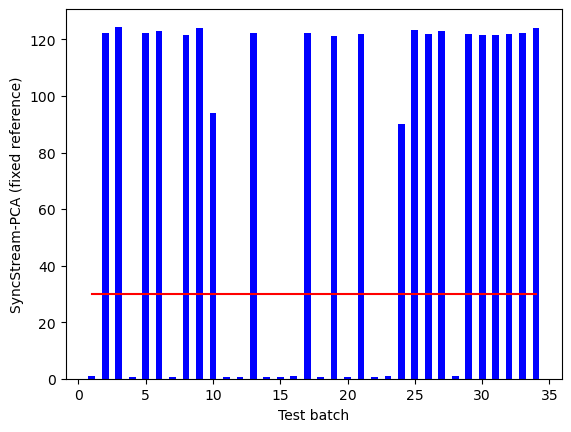

syncstream_pca_all took 0.2124500274658203 seconds
      TEMP  DEWP     SLP  VISIB  WDSP  MXSPD    MAX   MIN
6053  73.0  60.4  1018.0   15.0   3.9    9.9   82.9  61.0
6054  74.5  62.3  1017.2   15.4   3.1    8.9   91.0  61.0
6055  81.4  64.3  1012.7   14.9   4.4   10.9   93.9  69.1
6056  82.4  69.3  1010.1   14.7   5.7   12.8   96.1  70.0
6057  86.6  71.5  1008.1   14.9   6.9   11.8  100.0  75.0
[0.7787480718483534, 1.6715751069372566, 2.1019319217894443, 0.32272749577282994, 5.611904362390101, 4.1941068545787745, 0.03939474383917396, 2.441756826400079, 1.0502442051164702, 3.2211799373025856, 2.912180724152065, 1.898622267352974, 7.07092409341507, 4.367014176739232, 4.197476804257809, 6.578338443433933, 1.9602313679960421, 0.08625050980000012, 7.423556819517636, 0.7183836111332348, 6.648030643093643, 4.684380216250366, 4.5366347976968235, 4.444035356043495, 4.386276620752714, 5.356048838406287, 4.6338387388370155, 5.357354742582482, 4.321901067418218, 0.5724929693107934, 1.954603963466

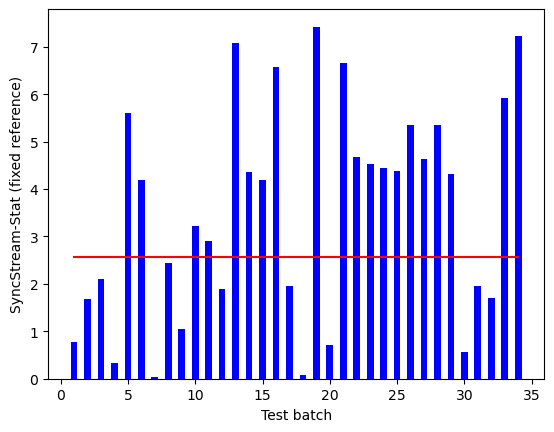

syncstream_stat_all took 3.1728477478027344 seconds
      TEMP  DEWP     SLP  VISIB  WDSP  MXSPD    MAX   MIN
6053  73.0  60.4  1018.0   15.0   3.9    9.9   82.9  61.0
6054  74.5  62.3  1017.2   15.4   3.1    8.9   91.0  61.0
6055  81.4  64.3  1012.7   14.9   4.4   10.9   93.9  69.1
6056  82.4  69.3  1010.1   14.7   5.7   12.8   96.1  70.0
6057  86.6  71.5  1008.1   14.9   6.9   11.8  100.0  75.0
t 0 mean: 3.01399 std: 0.0 diff_std: inf time: 1.0225749015808105
t 1 mean: 2.95325 std: 0.06074 diff_std: inf time: 1.773259162902832
t 2 mean: 3.0723 std: 0.1755 diff_std: 1.88958 time: 2.5064001083374023
t 3 mean: 3.16899 std: 0.22616 diff_std: 0.28866 time: 3.260558843612671
t 4 mean: 3.16434 std: 0.2025 diff_std: 0.10463 time: 4.04149317741394
t 5 mean: 3.14784 std: 0.1885 diff_std: 0.06912 time: 4.7652812004089355
t 6 mean: 3.17711 std: 0.18867 diff_std: 0.0009 time: 5.509984016418457
t 7 mean: 3.14678 std: 0.19388 diff_std: 0.02758 time: 6.289772033691406
t 8 mean: 3.09177 std: 0.24003 

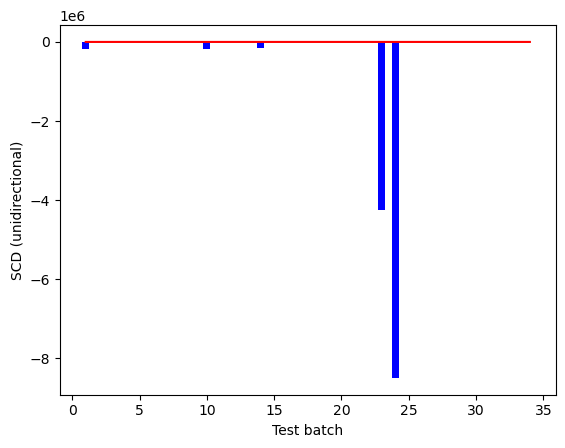

scd_all took 45.50753426551819 seconds

 real_world_data/weather_dataset.csv yearly encoder: None
PCA_ref: [2, 3, 5, 6, 8, 9, 10, 13, 17, 19, 21, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34] (0.6363636363636364, 0.0) Stat_ref: [5, 6, 10, 11, 13, 14, 15, 16, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 33, 34] (0.6060606060606061, 0.0) SCD_unidir: [1, 2, 4, 5, 6, 10, 12, 13, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 27, 29, 33, 34] (0.6363636363636364, 1.0)


          0         1         2         3         4         5         6  \
0  0.805389  0.840000  0.572727  0.634043  0.142857  0.169851  0.008558   
1  0.820359  0.858537  0.560606  0.651064  0.112782  0.148620  0.009368   
2  0.889222  0.878049  0.492424  0.629787  0.161654  0.191083  0.009657   
3  0.899202  0.926829  0.453030  0.621277  0.210526  0.231423  0.009877   
4  0.941118  0.948293  0.422727  0.629787  0.255639  0.210191  0.010267   

          7  
0  0.785495  
1  0.785495  
2  0.868233  
3  0.877426  
4  0.928498  
[88.6528077652

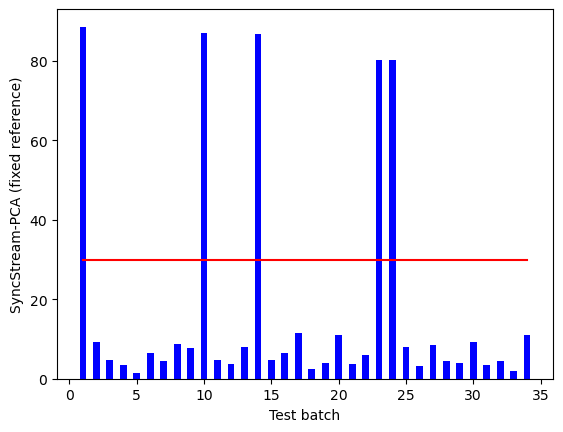

syncstream_pca_all took 0.2393038272857666 seconds
          0         1         2         3         4         5         6  \
0  0.805389  0.840000  0.572727  0.634043  0.142857  0.169851  0.008558   
1  0.820359  0.858537  0.560606  0.651064  0.112782  0.148620  0.009368   
2  0.889222  0.878049  0.492424  0.629787  0.161654  0.191083  0.009657   
3  0.899202  0.926829  0.453030  0.621277  0.210526  0.231423  0.009877   
4  0.941118  0.948293  0.422727  0.629787  0.255639  0.210191  0.010267   

          7  
0  0.785495  
1  0.785495  
2  0.868233  
3  0.877426  
4  0.928498  
[0.7787480718483534, 1.6715751069372566, 2.1019319217894443, 0.32272749577282994, 5.611904362390101, 4.1941068545787745, 0.03939474383917396, 2.441756826400079, 1.0502442051164702, 3.2211799373025856, 2.912180724152065, 1.898622267352974, 7.07092409341507, 4.367014176739232, 4.197476804257809, 6.578338443433933, 1.9602313679960421, 0.08625050980000012, 7.423556819517636, 0.7183836111332348, 6.648030643093643, 4

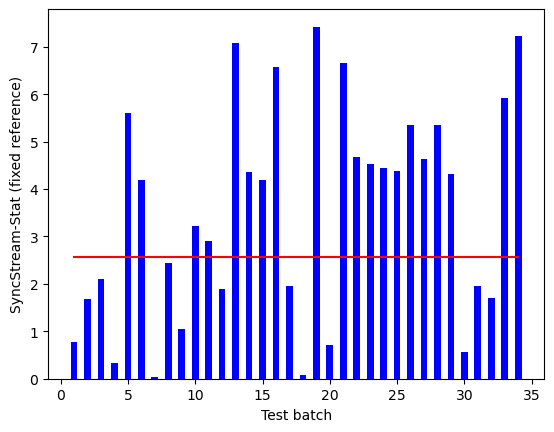

syncstream_stat_all took 3.0330097675323486 seconds
          0         1         2         3         4         5         6  \
0  0.805389  0.840000  0.572727  0.634043  0.142857  0.169851  0.008558   
1  0.820359  0.858537  0.560606  0.651064  0.112782  0.148620  0.009368   
2  0.889222  0.878049  0.492424  0.629787  0.161654  0.191083  0.009657   
3  0.899202  0.926829  0.453030  0.621277  0.210526  0.231423  0.009877   
4  0.941118  0.948293  0.422727  0.629787  0.255639  0.210191  0.010267   

          7  
0  0.785495  
1  0.785495  
2  0.868233  
3  0.877426  
4  0.928498  
t 0 mean: 3.38188 std: 0.0 diff_std: inf time: 0.8641388416290283
t 1 mean: 3.41079 std: 0.02891 diff_std: inf time: 1.639941930770874
t 2 mean: 3.41603 std: 0.02474 diff_std: 0.14423 time: 2.4291679859161377
t 3 mean: 3.436 std: 0.04069 diff_std: 0.64478 time: 3.2111411094665527
t 4 mean: 3.36291 std: 0.15064 diff_std: 2.70179 time: 3.965296983718872
t 5 mean: 3.3378 std: 0.14853 diff_std: 0.01397 time: 4.683

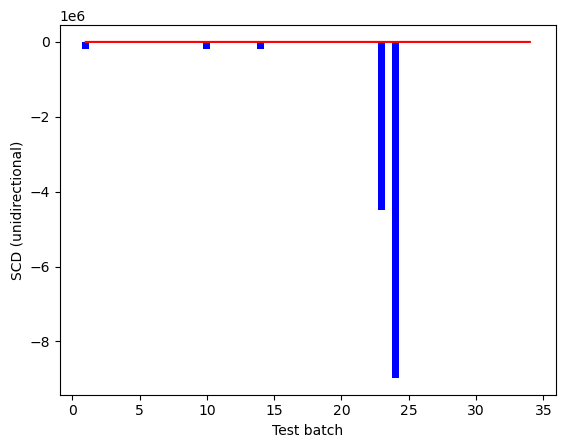

scd_all took 45.325483083724976 seconds

 real_world_data/weather_dataset.csv yearly encoder: None
PCA_ref: [1, 10, 14, 23, 24] (0.12121212121212122, 1.0) Stat_ref: [5, 6, 10, 11, 13, 14, 15, 16, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 33, 34] (0.6060606060606061, 0.0) SCD_unidir: [1, 4, 6, 10, 12, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 27, 29, 33, 34] (0.5454545454545454, 1.0)




In [12]:
def run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder=None, scaler=None):
    ref_data = X_train
    test_batches = X_test_batches
    ref_labels = y_train
    
    timer = time()
    drifts_pca_ref = syncstream_pca_all(ref_data, test_batches, ref_labels, encoder, scaler)
    print("syncstream_pca_all took", time() - timer, "seconds")
    
    timer = time()
    drifts_stat_ref = syncstream_stat_all(ref_data, test_batches, ref_labels, encoder, scaler)
    print("syncstream_stat_all took", time() - timer, "seconds")
    
    drifts_scd_unidir = []
    if encoder != "onehot": # due to matrix errors
        timer = time()
        drifts_scd_unidir = scd_all(ref_data, test_batches, ref_labels, encoder, scaler)
        print("scd_all took", time() - timer, "seconds")

#     drifts_scd_bidir = []
#     if encoder != "onehot": # due to matrix errors
#         drifts_scd_bidir = scd_all(ref_data, test_batches, ref_labels, encoder, scaler, bidirectional=True)

    print("\n", filename, "encoder:", encoder)
    report_1 = [
        "PCA_ref:",
        drifts_pca_ref,
        postprocess_rw(real_drifts, drifts_pca_ref, len(test_batches)),
        "Stat_ref:",
        drifts_stat_ref,
        postprocess_rw(real_drifts, drifts_stat_ref, len(test_batches)),
        "SCD_unidir:",
        drifts_scd_unidir,
        postprocess_rw(real_drifts, drifts_scd_unidir, len(test_batches))
    ]
    report_2 = [
#         "SCD_bidir:",
#         drifts_scd_bidir,
#         postprocess_rw(real_drifts, drifts_scd_bidir, len(test_batches))
    ]

    print(*report_1)
    print(*report_2, "\n")

def run_airlines():
    filename = "real_world_data/airline_dataset.csv"

    data = pd.read_csv(filename)
    df = pd.DataFrame(data)
    train = df.iloc[:179794,:]
    test = df.iloc[179794:,:]
    
    X_train = train.drop(columns=["Delay", "Unnamed: 0"])
    X_test = test.drop(columns=["Delay", "Unnamed: 0"])
    y_train = train[["Delay"]]
    y_test = test[["Delay"]]
    
    X_test_batches = []

    i = 0
    while i < len(X_test):
        new_i = i + 17000
        if new_i > len(X_test):
            new_i = len(X_test)
        X_test_batches.append(X_test[i: new_i])
        i = new_i
        
    # See drift definitions
    real_drifts = [2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22]

    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="onehot", scaler=None)
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="onehot", scaler="minmax")
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="ordinal", scaler=None)
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="ordinal", scaler="minmax")
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="target", scaler=None)
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="target", scaler="minmax")

def run_elect2():
    filename = "real_world_data/electricity_dataset.csv"
    
    data = pd.read_csv(filename)
    df = pd.DataFrame(data)
    
    df["day"] = df["day"].apply(lambda x: float(x.split("\'")[1]))
    
    train = df.iloc[:15104,:]
    test = df.iloc[15104:,:]
    
    X_train = train.drop(columns=["label", "Unnamed: 0", "real_date", "vicprice", "vicdemand"])
    X_test = test.drop(columns=["label", "Unnamed: 0", "real_date", "vicprice", "vicdemand"])
#     X_train = train.drop(columns=["label", "Unnamed: 0", "real_date", "vicprice", "vicdemand", "transfer"])
#     X_test = test.drop(columns=["label", "Unnamed: 0", "real_date", "vicprice", "vicdemand", "transfer"])
    y_train = train[["label"]]
    y_test = test[["label"]]
    
#     mms = MinMaxScaler()
#     X_train = pd.DataFrame(mms.fit_transform(X_train))
#     X_test = pd.DataFrame(mms.transform(X_test))
    
    print(X_train)
    print(np.linalg.matrix_rank(X_train))
    
    X_test_batches = []

    i = 0
    while i < len(X_test):
        new_i = i + 365
        if new_i > len(X_test):
            new_i = len(X_test)
        X_test_batches.append(X_test[i: new_i])
        i = new_i
    
    real_drifts = [1]
    
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder=None, scaler=None)
    
    
def run_weather(monthly):
    filename = "real_world_data/weather_dataset.csv"
    
    data = pd.read_csv(filename)
    df = pd.DataFrame(data)
    
    train = df.iloc[:6053,:]
    test = df.iloc[6053:,:]
    
    X_train = train.drop(columns=["Label_Rain", "Unnamed: 0"])
    X_test = test.drop(columns=["Label_Rain", "Unnamed: 0"])
    
    y_train = train[["Label_Rain"]]
    y_test = test[["Label_Rain"]]
    
    batch_size = 365
    label = filename + " yearly"
    if monthly:
        batch_size = 30
        label = filename + " monthly"
        
    X_test_batches = []
    
    i = 0
    while i < len(X_test):
        new_i = i + batch_size
        if new_i > len(X_test):
            new_i = len(X_test)
        X_test_batches.append(X_test[i: new_i])
        i = new_i
    
    real_drifts = [1]
        
    run_rw_detectors(X_train, X_test_batches, y_train, label, real_drifts, encoder=None, scaler=None)
    run_rw_detectors(X_train, X_test_batches, y_train, label, real_drifts, encoder=None, scaler="minmax")
    
    
# run_airlines()
# run_elect2()
# run_weather(monthly=True)
run_weather(monthly=False)

In [11]:
# For developing the stat/crit graphs

# deltas = [-129.7199403035309, -159.60035368695077, 1698.5442043309506, 3042.5968124774436, 3183.3992996155384, 899.6385798692045, 203.3835280193179]
# crits = [-462.82782072827405, -462.82782072827405, -462.82782072827405, -462.82782072827405, -462.82782072827405, -462.82782072827405, -462.82782072827405]
# y_label = "SCD (bidirectional)"
# deltas_reverse = [-626.5247613554766, 462.732832569769, 1228.4724605070069, 1428.1028153758189, 1252.3197326216869, -2360.207044655568, -2482.9791209586383]
# crits_reverse = [-1722.3482489631685, -1709.2903407223453, -1790.3885036189583, -1784.6916262708824, -1774.6846479583753, -1828.9015713027097, -1820.821524179729]

# graph(deltas, crits, y_label, deltas_reverse, crits_reverse)
